In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
np.random.seed(42)

# Number of data points
n_samples = 45000

# Generate date range covering approximately 2 years
start_date = datetime(2023, 1, 1)
date_list = [start_date + timedelta(hours=i) for i in range(n_samples)]

# Basic data
df = pd.DataFrame({
    'datetime': date_list,
    'date': [d.date() for d in date_list],
    'hour_of_day': [d.hour for d in date_list]
})

# Extract day of week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['datetime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['is_holiday'] = np.random.choice([0, 1], size=n_samples, p=[0.97, 0.03])  # 3% are holidays

# Create time-based patterns for traffic and ride requests
# Morning peak: 7-9 AM, Evening peak: 5-7 PM
df['is_peak_hour'] = df['hour_of_day'].apply(
    lambda x: 1 if (7 <= x <= 9) or (17 <= x <= 19) else 0
)

# Generate weather data
# Temperature (°C)
seasonal_temp = 15 + 10 * np.sin(2 * np.pi * (df.index % (365*24)) / (365*24))
df['temperature'] = seasonal_temp + np.random.normal(0, 3, n_samples)

# Rainfall (mm)
# Base probability of rain
rain_prob = 0.2 + 0.1 * np.sin(2 * np.pi * (df.index % (365*24)) / (365*24))
# Higher probability during certain hours (afternoon)
rain_prob = rain_prob + 0.1 * (df['hour_of_day'].between(13, 16))
df['rainfall'] = np.random.exponential(scale=2, size=n_samples) * np.random.binomial(1, rain_prob, n_samples)
df['rainfall'] = df['rainfall'].round(1)

# Wind speed (km/h)
df['wind_speed'] = np.random.gamma(shape=2, scale=5, size=n_samples)
df['wind_speed'] = df['wind_speed'].round(1)

# Traffic density (scale 1-10)
# Base traffic pattern based on hour of day
base_traffic = df['hour_of_day'].apply(lambda x: 
    8 if 7 <= x <= 9 else  # Morning peak
    7 if 16 <= x <= 19 else  # Evening peak
    5 if 10 <= x <= 15 else  # Midday
    3 if 20 <= x <= 22 else  # Evening
    1  # Night
)
# Add weekend effect (less traffic)
weekend_effect = df['is_weekend'] * -2
# Add weather effect (more traffic with rain)
rain_effect = 0.3 * df['rainfall']
# Add randomness
traffic_noise = np.random.normal(0, 1, n_samples)

df['traffic_density'] = base_traffic + weekend_effect + rain_effect + traffic_noise
df['traffic_density'] = df['traffic_density'].clip(1, 10).round(1)

# Ride requests - affected by time, traffic, weather, and special days
# Base ride requests pattern by hour
base_requests = df['hour_of_day'].apply(lambda x: 
    350 if 7 <= x <= 9 else  # Morning rush
    400 if 17 <= x <= 19 else  # Evening rush
    220 if 11 <= x <= 15 else  # Midday
    250 if 20 <= x <= 23 else  # Night life
    80  # Late night/early morning
)

# Weekend effect (more evening/night rides, fewer morning rides)
weekend_effect = df.apply(lambda row: 
    -100 if row['is_weekend'] == 1 and 7 <= row['hour_of_day'] <= 9 else  # Fewer morning rides
    100 if row['is_weekend'] == 1 and 19 <= row['hour_of_day'] <= 23 else  # More evening rides
    0, axis=1
)

# Weather effects (more rides during rain)
rain_effect = 50 * np.log1p(df['rainfall'])

# Holiday effect (similar to weekends)
holiday_effect = df['is_holiday'] * 100

# Temperature effect (fewer rides in extreme temperatures)
temp_effect = -3 * (df['temperature'] - 22)**2 / 10

# Random noise
request_noise = np.random.normal(0, 30, n_samples)

df['ride_requests'] = base_requests + weekend_effect + rain_effect + holiday_effect + temp_effect + request_noise
df['ride_requests'] = df['ride_requests'].clip(50, 600).astype(int)

# Driver availability - affected by time, weather, and traffic
# Base driver pattern by hour
base_drivers = df['hour_of_day'].apply(lambda x: 
    260 if 7 <= x <= 9 else  # Morning rush
    280 if 17 <= x <= 19 else  # Evening rush
    200 if 11 <= x <= 15 else  # Midday
    180 if 20 <= x <= 23 else  # Night life
    100  # Late night/early morning
)

# Weekend effect (fewer drivers in morning, more in evening)
driver_weekend_effect = df.apply(lambda row: 
    -50 if row['is_weekend'] == 1 and 7 <= row['hour_of_day'] <= 9 else
    30 if row['is_weekend'] == 1 and 19 <= row['hour_of_day'] <= 23 else
    0, axis=1
)

# Weather effects (fewer drivers during bad weather)
driver_rain_effect = -30 * np.log1p(df['rainfall'])

# Traffic effect (fewer drivers in heavy traffic)
traffic_effect = -10 * (df['traffic_density'] / 10)**2

# Random noise
driver_noise = np.random.normal(0, 20, n_samples)

df['active_drivers'] = base_drivers + driver_weekend_effect + driver_rain_effect + traffic_effect + driver_noise
df['active_drivers'] = df['active_drivers'].clip(80, 350).astype(int)

# Supply-demand ratio
df['supply_demand_ratio'] = df['active_drivers'] / df['ride_requests']

# Create surge multiplier based on supply-demand ratio
df['surge_multiplier'] = df['supply_demand_ratio'].apply(lambda x:
    1.0 if x >= 1.0 else
    1.2 if x >= 0.8 else
    1.5 if x >= 0.6 else
    1.8 if x >= 0.45 else
    2.0
)

# Trip cancellation rate (percentage)
df['cancellation_rate'] = (5 + 
                          15 * (1 - df['supply_demand_ratio']).clip(0, 1) +  # Higher when supply is low
                          5 * np.log1p(df['rainfall']) +  # Higher in rain
                          np.random.normal(0, 2, n_samples))  # Random noise
df['cancellation_rate'] = df['cancellation_rate'].clip(1, 30).round(1)

# Average wait time (minutes)
df['avg_wait_time'] = (3 + 
                      10 * (1 - df['supply_demand_ratio']).clip(0, 1) +  # Higher when supply is low
                      1 * df['traffic_density'] / 10 +  # Higher in traffic
                      0.5 * np.log1p(df['rainfall']) +  # Higher in rain
                      np.random.normal(0, 1, n_samples))  # Random noise
df['avg_wait_time'] = df['avg_wait_time'].clip(2, 20).round(1)

# Average trip duration (minutes)
base_duration = 15  # Base trip time
df['avg_trip_duration'] = (base_duration + 
                         5 * df['traffic_density'] / 10 +  # Traffic effect
                         2 * np.log1p(df['rainfall']) +  # Rain effect
                         np.random.normal(0, 2, n_samples))  # Random variation
df['avg_trip_duration'] = df['avg_trip_duration'].clip(10, 35).round(1)

# Add geographic zone information (5 zones)
df['zone_id'] = np.random.randint(1, 6, size=n_samples)

# Add pricing data
base_price = 5  # Base fare in currency units
df['avg_fare'] = (base_price + 
                 0.5 * df['avg_trip_duration'] +  # Time component
                 df['surge_multiplier'] * 2 +  # Surge effect
                 np.random.normal(0, 1, n_samples))  # Random variation
df['avg_fare'] = df['avg_fare'].clip(5, 30).round(1)

# Adjust correlations to match requirements

# Make stronger correlation between ride_requests and hour_of_day
peak_boost = df['is_peak_hour'] * np.random.uniform(50, 100, n_samples)
df['ride_requests'] = df['ride_requests'] + peak_boost
df['ride_requests'] = df['ride_requests'].astype(int)

# Strengthen correlation between ride_requests and rainfall
rain_boost = 30 * np.log1p(df['rainfall']) * np.random.uniform(0.8, 1.2, n_samples)
df['ride_requests'] = df['ride_requests'] + rain_boost
df['ride_requests'] = df['ride_requests'].astype(int)

# Recalculate supply-demand ratio after adjustments
df['supply_demand_ratio'] = df['active_drivers'] / df['ride_requests']

# Update surge multiplier based on new ratio
df['surge_multiplier'] = df['supply_demand_ratio'].apply(lambda x:
    1.0 if x >= 1.0 else
    1.2 if x >= 0.8 else
    1.5 if x >= 0.6 else
    1.8 if x >= 0.45 else
    2.0
)

# Ensure peak hours have lower supply-demand ratio
peak_hour_adjustment = df['is_peak_hour'] * np.random.uniform(20, 50, n_samples)
df.loc[df['is_peak_hour'] == 1, 'active_drivers'] = df.loc[df['is_peak_hour'] == 1, 'active_drivers'] - peak_hour_adjustment[df['is_peak_hour'] == 1]
df['active_drivers'] = df['active_drivers'].clip(80, 350).astype(int)

# Final recalculation of supply-demand ratio
df['supply_demand_ratio'] = df['active_drivers'] / df['ride_requests']

# Check correlations
correlation_matrix = df[['hour_of_day', 'ride_requests', 'rainfall', 'traffic_density', 
                         'active_drivers', 'supply_demand_ratio', 'surge_multiplier']].corr()

# Output the dataset
df.to_csv('ridesharing_data.csv', index=False)
print(f"Average supply-demand ratio during non-peak hours: {non_peak_ratio:.2f}")

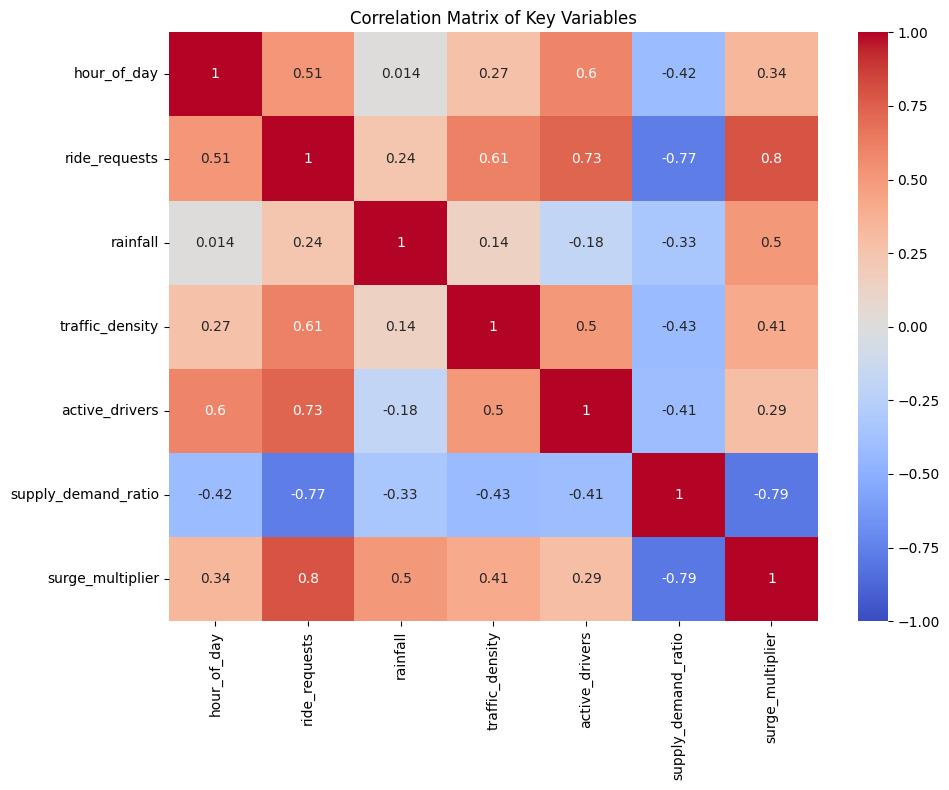

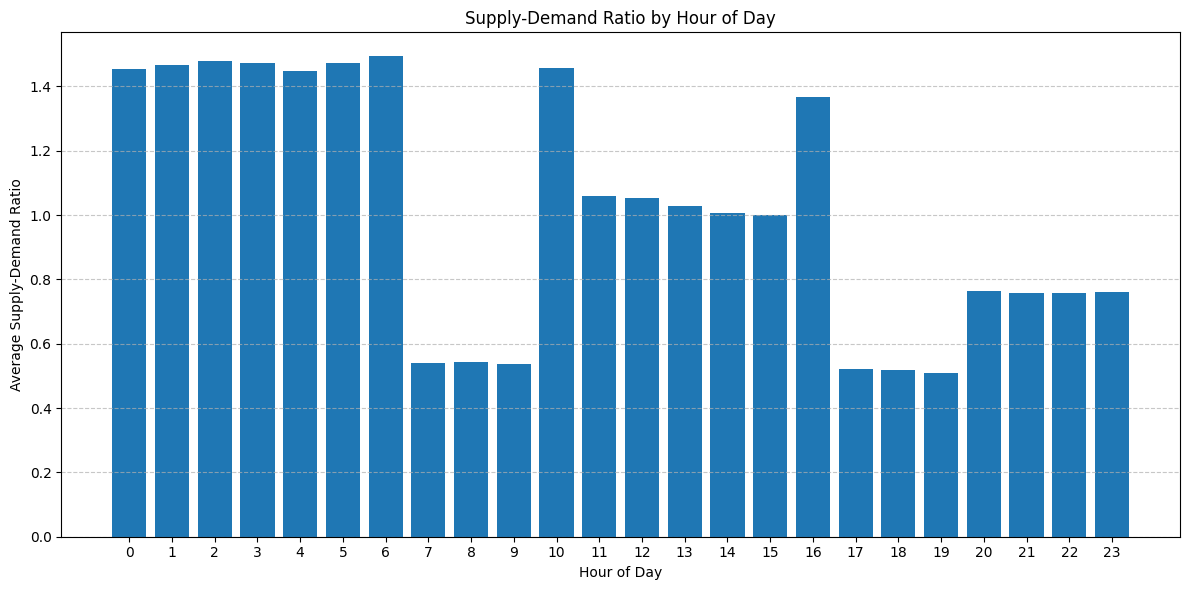

In [5]:

# Let's visualize some key relationships to verify
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

# Plot supply-demand ratio by hour of day
plt.figure(figsize=(12, 6))
hourly_ratio = df.groupby('hour_of_day')['supply_demand_ratio'].mean()
plt.bar(hourly_ratio.index, hourly_ratio.values)
plt.xlabel('Hour of Day')
plt.ylabel('Average Supply-Demand Ratio')
plt.title('Supply-Demand Ratio by Hour of Day')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('supply_demand_by_hour.png')


In [4]:

# Sample data structure
sample_data = df.head()
print("Sample data structure:")
print(sample_data)

# Correlation verification
print("\nVerifying key correlations:")
key_correlations = {
    'ride_requests vs hour_of_day': correlation_matrix.loc['ride_requests', 'hour_of_day'],
    'ride_requests vs rainfall': correlation_matrix.loc['ride_requests', 'rainfall'],
    'traffic_density vs hour_of_day': correlation_matrix.loc['traffic_density', 'hour_of_day'],
    'active_drivers vs traffic_density': correlation_matrix.loc['active_drivers', 'traffic_density'],
    'active_drivers vs rainfall': correlation_matrix.loc['active_drivers', 'rainfall']
}
for pair, value in key_correlations.items():
    print(f"{pair}: {value:.2f}")

# Check supply-demand ratios during peak vs non-peak hours
# This is where the error occurred - these variables need to be defined before using them in print statements
peak_ratio = df[df['is_peak_hour'] == 1]['supply_demand_ratio'].mean()
non_peak_ratio = df[df['is_peak_hour'] == 0]['supply_demand_ratio'].mean()
print(f"\nAverage supply-demand ratio during peak hours: {peak_ratio:.2f}")


Sample data structure:
             datetime        date  hour_of_day  day_of_week  is_weekend  \
0 2023-01-01 00:00:00  2023-01-01            0            6           1   
1 2023-01-01 01:00:00  2023-01-01            1            6           1   
2 2023-01-01 02:00:00  2023-01-01            2            6           1   
3 2023-01-01 03:00:00  2023-01-01            3            6           1   
4 2023-01-01 04:00:00  2023-01-01            4            6           1   

   is_holiday  is_peak_hour  temperature  rainfall  wind_speed  \
0           0             0    18.036093       0.0         4.0   
1           0             0    13.376991       2.4         7.2   
2           0             0    18.920884       0.0        11.2   
3           0             0    12.176349       0.0        10.7   
4           0             0    19.446930       0.0        20.3   

   traffic_density  ride_requests  active_drivers  supply_demand_ratio  \
0              1.0             50             101      

In [5]:
data = pd.read_csv("Rapido data/ct_rr.csv")

/tmp/ipykernel_29397/2934219336.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Rapido data/ct_rr.csv")


In [6]:
data.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng
0,2018-04-07 07:07:17,14626,12.313621,76.658195,12.287301,76.602280
1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.543770
2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.569950
3,2018-04-07 07:38:00,58940,12.918229,77.607544,12.968971,77.636375
4,2018-04-07 07:39:29,05408,12.899490,77.587270,12.934780,77.569950
